<a href="https://colab.research.google.com/github/lilydoggy0714-cmyk/MNIST/blob/main/W2%2050%E9%AB%98%E6%95%8F%E7%B6%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random, time

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
batch_size = 128
z_dim = 100            # 隨機噪聲維度
num_classes = 10       # MNIST 0~9
hidden_dim = 256       # 調整隱藏層大小
epochs = 50            # 訓練迴圈數
lr = 2e-4              # Adam學習率
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # 標準化到 [-1, 1]
])
trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.01MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.1MB/s]


In [5]:
#建立模型
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, img_shape):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)  # one-hot embedding

        self.model = nn.Sequential(
            nn.Linear(z_dim + num_classes, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.BatchNorm1d(hidden_dim*2),
            nn.ReLU(True),
            nn.Linear(hidden_dim*2, int(np.prod(img_shape))),
            nn.Tanh()
        )
        self.img_shape = img_shape

    def forward(self, noise, labels):
        # labels 轉 one-hot
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *self.img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self, num_classes, img_shape):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)) + num_classes, hidden_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        self.img_shape = img_shape

    def forward(self, img, labels):
        label_input = self.label_emb(labels)
        d_in = torch.cat((img.view(img.size(0), -1), label_input), -1)
        validity = self.model(d_in)
        return validity

In [6]:
img_shape = (1, 28, 28)
generator = Generator(z_dim, num_classes, img_shape).to(device)
discriminator = Discriminator(num_classes, img_shape).to(device)

criterion = nn.BCELoss()  # 二元交叉熵損失
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [7]:
# 訓練迴圈
print("開始訓練 cGAN ...")
start_time = time.time()
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size_curr = imgs.size(0)

        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # Label smoothing: 真實樣本的標籤不設成1，而是0.9
        valid = torch.full((batch_size_curr, 1), 0.9, device=device)
        fake = torch.full((batch_size_curr, 1), 0.0, device=device)

        # --------- 訓練 Generator ---------
        optimizer_G.zero_grad()
        z = torch.randn(batch_size_curr, z_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size_curr,), device=device)
        gen_imgs = generator(z, gen_labels)
        g_loss = criterion(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # --------- 訓練 Discriminator ---------
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs, labels), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/{epochs}]  D loss: {d_loss.item():.4f}  G loss: {g_loss.item():.4f}")
end_time = time.time()  # 結束計時
elapsed_time = end_time - start_time  # 總秒數

hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)
print(f"訓練模型時間: {hours} 時 {minutes} 分 {seconds} 秒")

開始訓練 cGAN ...
Epoch [1/50]  D loss: 0.4184  G loss: 1.2346
Epoch [2/50]  D loss: 0.6810  G loss: 2.3790
Epoch [3/50]  D loss: 0.4772  G loss: 1.8513
Epoch [4/50]  D loss: 0.3613  G loss: 1.4888
Epoch [5/50]  D loss: 0.3969  G loss: 1.6015
Epoch [6/50]  D loss: 0.5021  G loss: 2.1599
Epoch [7/50]  D loss: 0.4399  G loss: 1.7732
Epoch [8/50]  D loss: 0.5015  G loss: 2.1023
Epoch [9/50]  D loss: 0.5120  G loss: 0.9942
Epoch [10/50]  D loss: 0.6455  G loss: 2.3430
Epoch [11/50]  D loss: 0.5072  G loss: 1.5595
Epoch [12/50]  D loss: 0.4613  G loss: 1.2130
Epoch [13/50]  D loss: 0.4783  G loss: 1.2032
Epoch [14/50]  D loss: 0.5484  G loss: 0.9025
Epoch [15/50]  D loss: 0.5262  G loss: 1.0614
Epoch [16/50]  D loss: 0.5649  G loss: 1.0535
Epoch [17/50]  D loss: 0.5559  G loss: 1.2243
Epoch [18/50]  D loss: 0.5977  G loss: 0.7714
Epoch [19/50]  D loss: 0.5904  G loss: 1.0929
Epoch [20/50]  D loss: 0.6175  G loss: 0.8050
Epoch [21/50]  D loss: 0.5838  G loss: 0.9788
Epoch [22/50]  D loss: 0.6165

生成 100 張影像耗時: 0.003554 秒


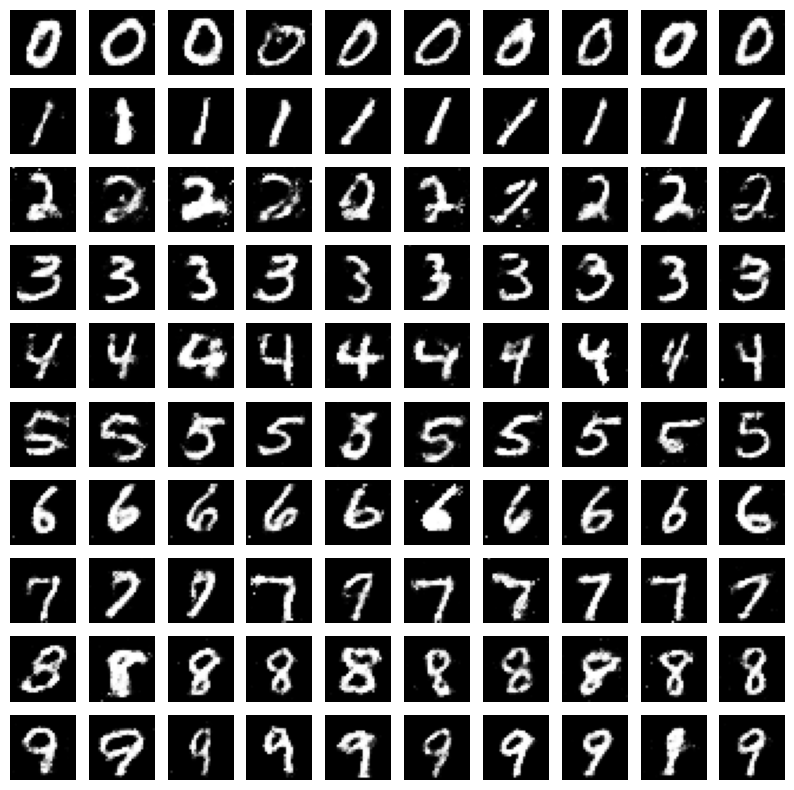

In [8]:
# 測試：生成數字 0–9 各 10 張
generator.eval()
n_row = 10
z = torch.randn(n_row**2, z_dim, device=device)
labels = torch.tensor([i for i in range(n_row) for _ in range(n_row)], device=device)

# 加入計時器
start_time = time.time()
gen_imgs = generator(z, labels).cpu().detach()
end_time = time.time()
print(f"生成 {n_row*n_row} 張影像耗時: {end_time - start_time:.6f} 秒")

# 把影像轉回 [0,1]
gen_imgs = (gen_imgs + 1) / 2.0

# 畫圖 (10x10)
fig, axs = plt.subplots(n_row, n_row, figsize=(10,10))
cnt = 0
for i in range(n_row):
    for j in range(n_row):
        axs[i,j].imshow(gen_imgs[cnt,0,:,:], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()